## The Task
The "Bag of Words" data set from the UCI Machine Learning Repository contains five text collections in the form of bags-of-words. The URL for the UCI repository is https://archive.ics.uci.edu/ml/datasets/Bag+of+Words.

Your task is to cluster the documents in these datasets via K-means clustering for different values of K and determine an optimum value of K.

As a similarity measure, use Jaccard index, that measures similarity between two documents based on the overlap of words present in both documents. Note that this changes the underlying model from "bag of words" to "set of words".

The datasets are of different sizes. Report your results on the three smaller datasets (Enron emails, NIPS blog entries, KOS blog entries).

## The Data Set
In each of the text collections, each document is summarized as a bag (multiset) of words. The individual documents are identified by document IDs and the words are identified by word IDs.

After some cleaning up, in each collection the vocabulary of unique words has been truncated to only keep words that occurred more than ten times overall in that collection.

For each collection XYZ:

vocab.XYZ.txt is the vocabulary file, listing all words that appear in the collection XYZ, one word per line. Each word has an implicit wordID that is its line number in this file, starting with 1 (the word on line 1 has wordID 1, the word on line 2 has wordID 2, ...)

docword.XYZ.txt lists out the number of times each word in vocab.XYZ.txt occurs in each document (only non-zero counts are recorded).

The file docword.XYZ.txt begins with 3 header lines

	  D
	  W
	  NNZ

where D is the number of documents in the collection, W is the number of words whose frequency is counted (i.e., W is the number of words in vocab.XYZ.txt) and NNZ is the number of non-zero frequency entries for this collection (i.e., NNZ is 3 less than the number of lines in docword.XYZ.txt).

This is followed by NNZ lines of the form

	  docID wordID count

where count is the number of time the word with id wordID appears in document with id docID. Remember that only non-zero counts are recorded.

Information about the datasets in the repository (that you need to analyze)
Enron Emails:
orig source: www.cs.cmu.edu/~enron
	  D=39861
	  W=28102
	  N=6,400,000 (approx)

NIPS full papers:
orig source: books.nips.cc
	  D=1500
	  W=12419
	  N=1,900,000 (approx)

KOS blog entries:
orig source: dailykos.com
	  D=3430
	  W=6906
	  N=467714

## Solving the Task
You can use any programming language, including Python and R. You can make use of standard packages for analytics and machine learning. Clearly document any external packages used by your code.

Submit the following via Moodle, as a Jupyter notebook if you are using Python and as a single archive (zip, tar.gz, …) otherwise:

The code you used to solve the assignment.

If you have voluminous output to report, save it somewhere on the cloud and provide a link.

A short write up describing how your code ran on the data sets: the parameters used, time taken, space required, and anything else of interest.

You may work alone or in groups of two. Each group makes a single submission to Moodle. Use either person's Moodle account to submit. The submission should mention the names of the two partners.

There will be a short oral presentation and question/answer session for each submission.

# Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

#Functions

## Custom K means

K Means Algorithm

1. Choose K points initially as random centroids
2. In each iteration
    1. Assign each point to nearest centroid
    2. Recompute centroids
3. Termination
    1. Clusters stabilize, or
    2. Sum square distance is below threshold

### Random Initialisation $∝$ probabilities ≡ distance

In [ ]:
def kmeans_plusplus(X, k): # X is a list of lists
    centroids = []

    # Randomly select the first centroid from data points
    centroids.append(X[np.random.randint(X.shape[0])])
    #print('centroid =', centroids)

    # Repeat until k centroids are chosen
    for _ in range(1, k):

        # Calculate squared distances from each point to this 'centroids' and store it in a list
        distances = np.array([[np.linalg.norm(x - c)**2 for c in centroids][0] for x in X])
        #print('distances in iter', _ ,':-', distances )

        # Choose the next centroid with probability proportional to squared distance
        probabilities = distances / distances.sum()
        centroids.append(X[np.random.choice(X.shape[0], p=probabilities)])

    return np.array(centroids)

In [ ]:
#Test

np.random.seed(0)
X = np.array([[0,0],
              [0,1],
              [2,3],
              [3,4],
              [1,3]])

kmeans_plusplus(X, 3)

# [1st centroid: [1, 3],
#  2nd centroid: [0, 1],
#  3rd centroid: [3, 4]]
# 3 centroids because k = 3
# the 3 centroids are a representative of its cluster

array([[1, 3],
       [0, 1],
       [3, 4]])

### Function to store the points in their respective clusters

In [ ]:
def assign_clusters(X, centroids):
    clusters = [[] for _ in range(len(centroids))] # e.g., clusters = [[points of cluster 1],[...],[...]] for k = 3
                                                   # which will store the points of the respective clusters

    for x in X:

        # Calculate distances from this point to each centroid
        distances = [np.linalg.norm(x - c) for c in centroids]
        #print('distances from', x , 'to each centroid', distances)

        # Assign the point to the cluster with the nearest centroid
        cluster_index = np.argmin(distances)
        #print('∴ the cluster-index of the point', x, ':-', cluster_index)

        clusters[cluster_index].append(x) #put the point x in clusters[cluster_index]

    return [np.array(cluster) for cluster in clusters]

In [ ]:
#Test

np.random.seed(0)
X = np.array([[0,0],
              [0,1],
              [2,3],
              [3,4],
              [1,3]])

clusters = kmeans_plusplus(X, 3)
for i in range(len(assign_clusters(X, clusters))):
    print('cluster', i+1, '\n', assign_clusters(X, clusters)[i])

cluster 1 
 [[2 3]
 [1 3]]
cluster 2 
 [[0 0]
 [0 1]]
cluster 3 
 [[3 4]]


### Function to Update centroids after each iteration

In [ ]:
def update_centroids(clusters):
    return [np.mean(cluster, axis=0) for cluster in clusters]

# e.g., np.mean(np.array([[1, 2],
#                   [3, 6]]), axis=1) = array([1.5, 4.5])

In [ ]:
update_centroids(assign_clusters(X, clusters))

[array([1.5, 3. ]), array([0. , 0.5]), array([3., 4.])]

### The Main K-Means function implemented with K-Means ++

In [ ]:
def kmeans(X, k, max_iterations=100, tol=1e-04):

    # Initialize centroids using k-means++
    centroids = kmeans_plusplus(X, k)

    for _ in range(max_iterations):
        # Assign points to clusters
        clusters = assign_clusters(X, centroids)
        # Update centroids
        new_centroids = update_centroids(clusters)

        # If centroids stop changing, break the loop
        if np.allclose(centroids, new_centroids, rtol=0, atol=tol, equal_nan=True):
            break
        centroids = new_centroids

    return centroids, clusters

In [ ]:
# Example usage:

np.random.seed(0)
X = np.array([[0,0],
              [0,1],
              [2,3],
              [3,4],
              [1,3]])

k = 2

centroids, clusters = kmeans(X, k)

for i, centroid in enumerate(centroids):
    print(f"Centroid {i+1} '\n' {centroid}")
    print(f"Cluster {i+1} '\n' {clusters[i]}")
    print()

Centroid 1 '
' [2.         3.33333333]
Cluster 1 '
' [[2 3]
 [3 4]
 [1 3]]

Centroid 2 '
' [0.  0.5]
Cluster 2 '
' [[0 0]
 [0 1]]



## Functions for Jaccard Distance

In [ ]:
def jaccard_dist(list1, list2):
    set1 = set(filter(lambda x: x != 0, list1))
    set2 = set(filter(lambda x: x != 0, list2))
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    jaccard_index = 1- intersection / union if union != 0 else 0
    return jaccard_index

In [ ]:
jaccard_dist([1,2],[1,2,3])

0.33333333333333337

In [ ]:
jaccard_dist([1,2,0,0,0,0],[1,2,3,0,0,0])

0.33333333333333337

## Functions to find the optimal k using the inertia - elbow method

In [ ]:
def compute_inertia(centroids, clusters):
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster = clusters[i]
        inertia += np.sum(np.linalg.norm(cluster - centroid, axis=1) ** 2)
    return inertia

def plot_k_vs_inertia(k_list, inertia_values):
    plt.plot(k_list, inertia_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

# Dataset Preprocessing


In [ ]:
df1 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\vocab.nips.txt")
df1.to_csv('vnips.csv', index = None)

df2 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\vocab.enron.txt")
df2.to_csv('venron.csv', index = None)

df3 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\vocab.kos.txt")
df3.to_csv('vkos.csv', index = None)

In [ ]:
df4 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\docword.nips.txt")
df4.to_csv('dnips.csv', index = None)

df5 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\docword.enron.txt")
df5.to_csv('denron.csv', index = None)

df6 = pd.read_csv("C:\\Users\\hp\\Desktop\\DMML_Assignment-2\\docword.kos.txt")
df6.to_csv('dkos.csv', index = None)

In [ ]:
# Reading files for processing
d_names = ['doc_id', 'Word_id', 'count']

denron = pd.read_csv("denron.csv", header=None, skiprows=3, names=d_names, sep=" ")
venron = pd.read_csv("venron.csv", header=None).reset_index().rename(columns={0: 'Word'}).rename(columns={'index': 'Word_id'})[['Word_id', 'Word']]
venron['Word_id'] += 1

dkos = pd.read_csv("dkos.csv", header=None, skiprows=3, names=d_names, sep=" ")
vkos = pd.read_csv("vkos.csv", header=None).reset_index().rename(columns={0: 'Word'}).rename(columns={'index': 'Word_id'})[['Word_id', 'Word']]
vkos['Word_id'] += 1

dnips = pd.read_csv("dnips.csv", header=None, skiprows=3, names=d_names, sep=" ")
vnips = pd.read_csv("vnips.csv", header=None).reset_index().rename(columns={0: 'Word'}).rename(columns={'index': 'Word_id'})[['Word_id', 'Word']]
vnips['Word_id'] += 1

$vocab.XYZ.txt$ is the vocabulary file, listing all words that appear in the collection XYZ, one word per line.
> $WordID$ - $word$ ; $WordID$ $\geq$ $1$


In [ ]:
venron.head()

,Word_id,Word
0,1,aaa
1,2,aaas
2,3,aactive
3,4,aadvantage
4,5,aaker


In [ ]:
vkos.head()

,Word_id,Word
0,1,aarp
1,2,abandon
2,3,abandoned
3,4,abandoning
4,5,abb


In [ ]:
vnips.head()

,Word_id,Word
0,1,a2i
1,2,aaa
2,3,aaai
3,4,aapo
4,5,aat


$docword.XYZ.txt$ lists out the number of times each word in $vocab.XYZ.txt$ occurs in each document (only non-zero counts are recorded).

The file docword.XYZ.txt begins with $3$ header lines

	  D
	  W
	  NNZ

where $D$ is the number of documents in the collection, $W$ is the number of words whose frequency is counted (i.e., $W$ is the number of words in $vocab.XYZ.txt$) and $NNZ$ is the number of non-zero frequency entries for this collection (i.e., $NNZ$ is $3$ less than the number of lines in docword.XYZ.txt).

This is followed by $NNZ$ lines of the form

	  docID wordID count

where count is the number of time the word with id $wordID$ appears in document with $id=docID$. Remember that only non-zero counts are recorded.

In [ ]:
denron.head(5)

,doc_id,Word_id,count
0,1,118,1
1,1,285,1
2,1,1229,1
3,1,1688,1
4,1,2068,1


In [ ]:
dkos.head()

,doc_id,Word_id,count
0,1,61,2
1,1,76,1
2,1,89,1
3,1,211,1
4,1,296,1


In [ ]:
dnips.head(10)

,doc_id,Word_id,count
0,1,2,1
1,1,39,1
2,1,42,3
3,1,77,1
4,1,95,1
5,1,96,1
6,1,105,1
7,1,108,1
8,1,133,3
9,1,137,2


# Clustering Enron Dataset

In [ ]:
merged_df = pd.merge(denron, venron, on='Word_id', how='inner')

In [ ]:
merged_df.isnull().sum()

doc_id      0
Word_id     0
count       0
Word       20
dtype: int64

In [ ]:
merged_df = merged_df.dropna()
merged_df.isnull().sum()

doc_id     0
Word_id    0
count      0
Word       0
dtype: int64

In [ ]:
merged_df.head()

,doc_id,Word_id,count,Word
0,1,118,1,access
1,86,118,7,access
2,93,118,3,access
3,108,118,2,access
4,127,118,1,access


In [ ]:
print("max doc_id = ",merged_df['doc_id'].max())
print("min doc_id = ",merged_df['doc_id'].min())
print("max Word_id = ",merged_df['Word_id'].max())
print("min Word_id = ",merged_df['Word_id'].min())
print("max count = ",merged_df['count'].max())
print("min count = ",merged_df['count'].min())

max doc_id =  39861
min doc_id =  1
max Word_id =  28102
min Word_id =  1
max count =  403
min count =  1


In [ ]:
df = merged_df.copy()
counts_dict = {}

for index, row in df.iterrows():
    doc_id = row['doc_id']
    word_id = row['Word_id']
    count = row['count']

    if doc_id in counts_dict:
        counts_dict[doc_id][word_id] = count
    else:
        counts_dict[doc_id] = {word_id: count}

In [ ]:
def sum(dic):
  sum = 0
  for i in dic.keys():
    sum+=dic[i]
  return(sum)
sum({1: 2, 3:4})

6

In [ ]:
max = 0
for i in counts_dict.keys():
  if sum(counts_dict[i]) > max:
    max = sum(counts_dict[i])
print(max)

4873


In [ ]:
doc_dic = {}
for i in range(1, merged_df['doc_id'].max()+1):
  doc_dic[i] = []
for i in doc_dic.keys():
  for j in counts_dict[i].keys():
    doc_dic[i] += [j for _ in range(counts_dict[i][j])]
  diff = max - len(doc_dic[i])
  doc_dic[i] += [0 for _ in range(diff)]

In [ ]:
len(doc_dic[3]), len(doc_dic[567])

(4873, 4873)

In [ ]:
doc_list = np.array([doc_dic[i] for i in doc_dic.keys()])

In [ ]:
kmeans(doc_list, 4, max_iterations=100, tol=1e-04)

([array([10866.53795716, 12512.98047501, 13606.37046481, ...,
             0.        ,     0.        ,     0.        ]),
  array([4031.4370915 , 6742.13439542, 8532.07066993, ...,    0.        ,
            0.        ,    0.        ]),
  array([ 6960.66518706,  9192.71750159, 10407.39811879, ...,
             0.        ,     0.        ,     0.        ]),
  array([ 348.63727455,  799.69539078, 1264.4488978 , ...,   14.39478958,
           14.89378758,   20.17034068])],
 [array([[  118,   285,  1229, ...,     0,     0,     0],
         [ 4802,  4802,  5602, ...,     0,     0,     0],
         [  285,   285,  5299, ...,     0,     0,     0],
         ...,
         [ 1583,  7392, 19409, ...,     0,     0,     0],
         [15084, 10636, 14611, ...,     0,     0,     0],
         [ 6993, 15617, 15617, ...,     0,     0,     0]]),
  array([[13631, 13631, 25611, ...,     0,     0,     0],
         [ 8904,  8904, 12669, ...,     0,     0,     0],
         [  285,   285,  5299, ...,     0,     

### Visualisation of the clusters using PCA

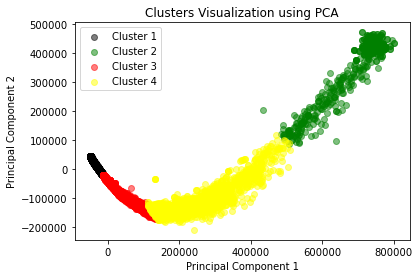

In [ ]:
# Flatten the array of clusters

res = kmeans(doc_list, 4, max_iterations=100, tol=1e-04)
array_of_clusters = res[1]
flattened_clusters = np.concatenate(array_of_clusters)

# Perform PCA to reduce dimensions
pca = PCA(n_components=2)
transformed_clusters = pca.fit_transform(flattened_clusters)

# Plot the clusters
colors = ['black', 'green', 'red', 'yellow', 'm', 'cyan']  # Define colors for clusters
for i, cluster in enumerate(array_of_clusters):
    transformed_cluster = pca.transform(cluster)
    plt.scatter(transformed_cluster[:, 0], transformed_cluster[:, 1], color=colors[i], label=f'Cluster {i+1}', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()

### Finding the optimal k

In [ ]:
np.random.seed(0)
k_list = range(3,11)
inertia_values = []
for k in k_list:
    centroids, clusters = kmeans(doc_list, k)
    inertia = compute_inertia(centroids, clusters)
    inertia_values.append(inertia)

In [ ]:
inertia_values

[764902130129618.5,
 670256284439711.1,
 614453716542561.6,
 579497088420080.2,
 553140191285934.06,
 532537142400705.5,
 518069293121198.56,
 504595783979978.6]

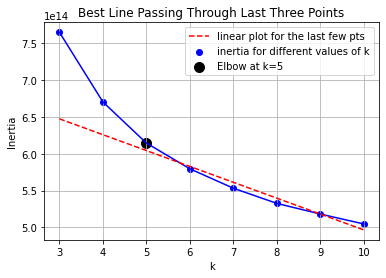

In [ ]:
points = [(764902130129618.50, 3),
          (670256284439711.10, 4),
          (614453716542561.60, 5),
          (579497088420080.20, 6),
          (553140191285934.06, 7),
          (532537142400705.50, 8),
          (518069293121198.56, 9),
          (504595783979978.60, 10)]
highlight_point = points[2]

x_values = [point[1] for point in points]
y_values = [point[0] for point in points]

X = np.array(x_values[-6:]).reshape(-1, 1)
y = np.array(y_values[-6:])
model = LinearRegression().fit(X, y)

first_x = x_values[0]
last_x = x_values[-1]
first_y = model.predict([[first_x]])[0]
last_y = model.predict([[last_x]])[0]

plt.scatter(x_values, y_values, color='blue', label='inertia for different values of k')
plt.plot(x_values, y_values, color='blue')

# Plot the best line passing through the last three points
plt.plot([first_x, last_x], [first_y, last_y], color='red', linestyle='--', label='linear plot for the last few pts')
plt.scatter(highlight_point[1], highlight_point[0], color='black', s=100, label='Elbow at k=5')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Best Line Passing Through Last Three Points')
plt.legend()
plt.grid(True)
plt.show()

# Clustering kos Dataset

In [ ]:
merged_df = pd.merge(dkos, vkos, on='Word_id', how='inner')

In [ ]:
merged_df.isnull().sum()

doc_id     0
Word_id    0
count      0
Word       0
dtype: int64

In [ ]:
merged_df = merged_df.dropna()
merged_df.isnull().sum()

doc_id     0
Word_id    0
count      0
Word       0
dtype: int64

In [ ]:
merged_df.head()

,doc_id,Word_id,count,Word
0,1,61,2,action
1,58,61,1,action
2,196,61,1,action
3,197,61,2,action
4,230,61,1,action


In [ ]:
print("max doc_id = ",merged_df['doc_id'].max())
print("min doc_id = ",merged_df['doc_id'].min())
print("max Word_id = ",merged_df['Word_id'].max())
print("min Word_id = ",merged_df['Word_id'].min())
print("max count = ",merged_df['count'].max())
print("min count = ",merged_df['count'].min())

max doc_id =  3430
min doc_id =  1
max Word_id =  6906
min Word_id =  1
max count =  43
min count =  1


In [ ]:
df = merged_df.copy()
counts_dict = {}

for index, row in df.iterrows():
    doc_id = row['doc_id']
    word_id = row['Word_id']
    count = row['count']

    if doc_id in counts_dict:
        counts_dict[doc_id][word_id] = count
    else:
        counts_dict[doc_id] = {word_id: count}

In [ ]:
def sum(dic):
  sum = 0
  for i in dic.keys():
    sum+=dic[i]
  return(sum)

In [ ]:
max = 0
for i in counts_dict.keys():
  if sum(counts_dict[i]) > max:
    max = sum(counts_dict[i])
print(max)

670


In [ ]:
doc_dic = {}
for i in range(1, merged_df['doc_id'].max()+1):
  doc_dic[i] = []
for i in doc_dic.keys():
  for j in counts_dict[i].keys():
    doc_dic[i] += [j for _ in range(counts_dict[i][j])]
  diff = max - len(doc_dic[i])
  doc_dic[i] += [0 for _ in range(diff)]

In [ ]:
len(doc_dic[3]), len(doc_dic[567])

(670, 670)

In [ ]:
doc_list = np.array([doc_dic[i] for i in doc_dic.keys()])

In [ ]:
kmeans(doc_list, 4, max_iterations=100, tol=1e-04)

([array([ 681.51222352, 1228.27590221, 1656.65075669, 2049.07683353,
         2339.5983702 , 2569.64726426, 2810.14202561, 3019.23166473,
         3266.5774156 , 3400.91152503, 3514.74155995, 3607.01746217,
         3726.56111758, 3813.89871944, 3871.77066356, 3910.96740396,
         3984.1862631 , 4070.98603027, 4179.14668219, 4144.73108265,
         4085.39813737, 3905.42491269, 3910.37834692, 3741.26426077,
         3699.27124563, 3608.3806752 , 3510.63678696, 3529.28172293,
         3437.71944121, 3424.05820722, 3306.68102445, 3204.79045402,
         3175.70197905, 3163.94412107, 3189.55529686, 3047.27590221,
         3116.81490105, 3145.54016298, 3154.30616997, 3157.29103609,
         3123.31781141, 3227.68568102, 3185.12456345, 3236.59022119,
         3260.90570431, 3261.74505239, 3300.45518044, 3347.05820722,
         3318.2782305 , 3343.95692666, 3240.39580908, 3302.49476135,
         3295.76018626, 3245.74621653, 3171.99301513, 3186.6193248 ,
         3280.57625146, 3255.00232

### Visualisation of the clusters using PCA

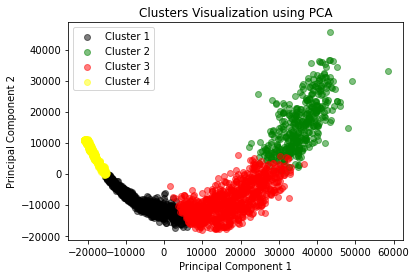

In [ ]:
# Flatten the array of clusters

res = kmeans(doc_list, 4, max_iterations=100, tol=1e-04)
array_of_clusters = res[1]
flattened_clusters = np.concatenate(array_of_clusters)

# Perform PCA to reduce dimensions
pca = PCA(n_components=2)
transformed_clusters = pca.fit_transform(flattened_clusters)

# Plot the clusters
colors = ['black', 'green', 'red', 'yellow', 'm', 'cyan']  # Define colors for clusters
for i, cluster in enumerate(array_of_clusters):
    transformed_cluster = pca.transform(cluster)
    plt.scatter(transformed_cluster[:, 0], transformed_cluster[:, 1], color=colors[i], label=f'Cluster {i+1}', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()

### Finding the optimal k

In [ ]:
np.random.seed(0)
k_list = range(3,16)
inertia_values = []
for k in k_list:
    centroids, clusters = kmeans(doc_list, k)
    inertia = compute_inertia(centroids, clusters)
    inertia_values.append(inertia)

In [ ]:
inertia_values, k_list

([2559160645885.465,
  2354579757935.886,
  2226132035025.147,
  2152686674161.5242,
  2094691931230.697,
  2090096062555.5488,
  2015073652338.3865,
  1979337874760.2874,
  1961110828042.6755,
  1931123081639.9297,
  1915682967972.4336,
  1901650982305.5918,
  1915692456642.2183],
 range(3, 16))

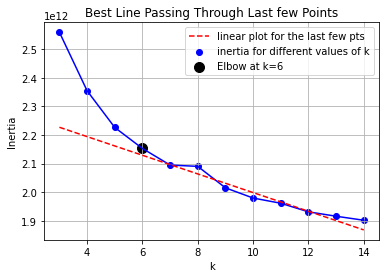

In [ ]:
points = [(2559160645885.4650, 3),
          (2354579757935.8860, 4),
          (2226132035025.1470, 5),
          (2152686674161.5242, 6),
          (2094691931230.6970, 7),
          (2090096062555.5488, 8),
          (2015073652338.3865, 9),
          (1979337874760.2874, 10),
          (1961110828042.6755, 11),
          (1931123081639.9297, 12),
          (1915682967972.4336, 13),
          (1901650982305.5918, 14)]

highlight_point = points[3]

x_values = [point[1] for point in points]
y_values = [point[0] for point in points]

X = np.array(x_values[-7:-1]).reshape(-1, 1)
y = np.array(y_values[-7:-1])
model = LinearRegression().fit(X, y)

first_x = x_values[0]
last_x = x_values[-1]
first_y = model.predict([[first_x]])[0]
last_y = model.predict([[last_x]])[0]

plt.scatter(x_values, y_values, color='blue', label='inertia for different values of k')
plt.plot(x_values, y_values, color='blue')

plt.plot([first_x, last_x], [first_y, last_y], color='red', linestyle='--', label='linear plot for the last few pts')
plt.scatter(highlight_point[1], highlight_point[0], color='black', s=100, label='Elbow at k=6')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Best Line Passing Through Last few Points')
plt.legend()
plt.grid(True)
plt.show()

# Clustering the Nips dataset

In [ ]:
merged_df = pd.merge(dnips, vnips, on='Word_id', how='inner')

In [ ]:
merged_df.isnull().sum()

doc_id      0
Word_id     0
count       0
Word       52
dtype: int64

In [ ]:
merged_df = merged_df.dropna()
merged_df.isnull().sum()

doc_id     0
Word_id    0
count      0
Word       0
dtype: int64

In [ ]:
merged_df.head()

,doc_id,Word_id,count,Word
0,1,2,1,aaa
1,8,2,1,aaa
2,380,2,3,aaa
3,417,2,1,aaa
4,744,2,1,aaa


In [ ]:
print("max doc_id = ",merged_df['doc_id'].max())
print("min doc_id = ",merged_df['doc_id'].min())
print("max Word_id = ",merged_df['Word_id'].max())
print("min Word_id = ",merged_df['Word_id'].min())
print("max count = ",merged_df['count'].max())
print("min count = ",merged_df['count'].min())

max doc_id =  1500
min doc_id =  1
max Word_id =  12419
min Word_id =  1
max count =  132
min count =  1


In [ ]:
df = merged_df.copy()
counts_dict = {}

for index, row in df.iterrows():
    doc_id = row['doc_id']
    word_id = row['Word_id']
    count = row['count']

    if doc_id in counts_dict:
        counts_dict[doc_id][word_id] = count
    else:
        counts_dict[doc_id] = {word_id: count}

In [ ]:
def sum(dic):
  sum = 0
  for i in dic.keys():
    sum+=dic[i]
  return(sum)

In [ ]:
max = 0
for i in counts_dict.keys():
  if sum(counts_dict[i]) > max:
    max = sum(counts_dict[i])
print(max)

2307


In [ ]:
doc_dic = {}
for i in range(1, merged_df['doc_id'].max()+1):
  doc_dic[i] = []
for i in doc_dic.keys():
  for j in counts_dict[i].keys():
    doc_dic[i] += [j for _ in range(counts_dict[i][j])]
  diff = max - len(doc_dic[i])
  doc_dic[i] += [0 for _ in range(diff)]

In [ ]:
len(doc_dic[3]), len(doc_dic[567])

(2307, 2307)

In [ ]:
doc_list = np.array([doc_dic[i] for i in doc_dic.keys()])

In [ ]:
kmeans(doc_list, 7, max_iterations=100, tol=1e-04)

([array([ 38.82580645, 103.36774194, 139.30967742, ...,   0.        ,
           0.        ,   0.        ]),
  array([ 40.00757576,  90.95454545, 115.37121212, ...,   6.02272727,
          51.29545455,  51.29545455]),
  array([1420.04545455, 2597.81818182, 3057.18181818, ...,    0.        ,
            0.        ,    0.        ]),
  array([ 39.2967033 , 100.00732601, 130.46886447, ...,   0.        ,
           0.        ,   0.        ]),
  array([ 40.17877095, 116.59217877, 166.51396648, ...,   0.        ,
           0.        ,   0.        ]),
  array([ 39.42758621,  99.03448276, 145.52068966, ...,   0.        ,
           0.        ,   0.        ]),
  array([ 38.86397059,  97.0625    , 126.12132353, ...,   0.        ,
           0.        ,   0.        ])],
 [array([[ 39,  39,  95, ...,   0,   0,   0],
         [ 39, 158, 316, ...,   0,   0,   0],
         [ 39,  95,  95, ...,   0,   0,   0],
         ...,
         [ 39,  42,  42, ...,   0,   0,   0],
         [ 39, 316, 316, ...,   

### Visualisation of the clusters using PCA

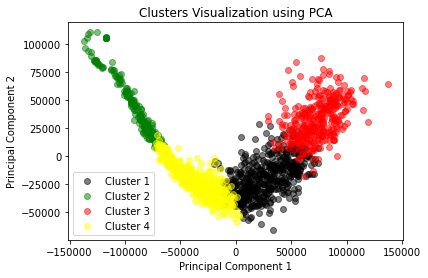

In [ ]:
res = kmeans(doc_list, 4, max_iterations=100, tol=1e-04)
array_of_clusters = res[1]
flattened_clusters = np.concatenate(array_of_clusters)

pca = PCA(n_components=2)
transformed_clusters = pca.fit_transform(flattened_clusters)

colors = ['black', 'green', 'red', 'yellow', 'magenta', 'cyan', 'blue']

for i, cluster in enumerate(array_of_clusters):
    transformed_cluster = pca.transform(cluster)
    plt.scatter(transformed_cluster[:, 0], transformed_cluster[:, 1], color=colors[i], label=f'Cluster {i+1}', alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization using PCA')
plt.legend()
plt.show()

### Finding the optimal k

In [ ]:
np.random.seed(0)
k_list = range(3,16)
inertia_values = []
for k in k_list:
    centroids, clusters = kmeans(doc_list, k)
    inertia = compute_inertia(centroids, clusters)
    inertia_values.append(inertia)

In [ ]:
inertia_values

[2559160645885.465,
 2354579757935.886,
 2226132035025.147,
 2152686674161.5242,
 2094691931230.697,
 2090096062555.5488,
 2015073652338.3865,
 1979337874760.2874,
 1961110828042.6755,
 1931123081639.9297,
 1915682967972.4336,
 1901650982305.5918,
 1915692456642.2183]

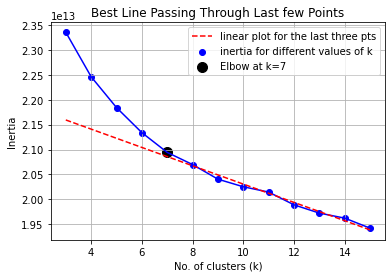

In [ ]:
points = [(23351427501271.453, 3),
          (22459057133259.688, 4),
          (21840768521552.883, 5),
          (21338597386034.227, 6),
          (20942332603451.305, 7),
          (20699180165205.957, 8),
          (20405796173804.246, 9),
          (20253872713484.207, 10),
          (20147154893574.180, 11),
          (19891364893703.400, 12),
          (19725689679587.280, 13),
          (19624986854184.047, 14),
          (19423500898410.150, 15)]

highlight_point = points[4]
x_values = [point[1] for point in points]
y_values = [point[0] for point in points]

X = np.array(x_values[-9:]).reshape(-1, 1)
y = np.array(y_values[-9:])
model = LinearRegression().fit(X, y)

first_x = x_values[0]
last_x = x_values[-1]
first_y = model.predict([[first_x]])[0]
last_y = model.predict([[last_x]])[0]

plt.scatter(x_values, y_values, color='blue', label='inertia for different values of k')
plt.plot(x_values, y_values, color='blue')

# Plot the best line passing through the last few points
plt.plot([first_x, last_x], [first_y, last_y], color='red', linestyle='--', label='linear plot for the last three pts')
plt.scatter(highlight_point[1], highlight_point[0], color='black', s=100, label='Elbow at k=7')
plt.xlabel('No. of clusters (k)')
plt.ylabel('Inertia')
plt.title('Best Line Passing Through Last few Points')
plt.legend()
plt.grid(True)
plt.show()